# Roomba simple

In [17]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Necesitamos agentes por celdas, usamos MultiGrid
from mesa.space import MultiGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Número de iteraciones
MAXVAL = 10000

## Cell automata
Each cell of our grid represents a room/space. We are restricting the roomba to move up, down, left, right
### Agent rules
#### The perception system
- 0 is Clean
- 1 is Dirty 

In [18]:
class VaccumCleaner(Agent):
    # initialize class, define id and space occupied (model)
    def __init__(self, id, model):
        super().__init__(id, model)
        
        # movement for the agent
        self.options = np.array([
            [-1,-1], [-1,0], [-1, 1],
            [0,-1],          [0, 1],
            [1,-1],  [1,0],  [1,1] ])
        
        # check if you can move around
        def can_move(self,x,y):
            return ((x >= 0 and x <= self.model.grid.width) and
                   (y >= 0 and y <= self.model.grid.height))
        
        
        # define what is done on each step
        def step(self):
            if self.model.cells[[self.pos[0]][self.pos[1]]] == 1:
                self.model.cells[[self.pos[0]][self.pos[1]]] = 0
            else:
                # the agent can collide several times on each step
                i = int(np.random.random() * MAXVAL % len(self.options))
                x_pos = self.pos[0] + self.options[i][0]
                y_pos = self.pos[1] + self.options[i][1]
                if self.can_move(x_pos, y_pos):
                    self.model.grid.move_agent(self, (x_pos, y_pos))

In [19]:
# save a copy of the matrix
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if not model.grid.is_cell_empty((x,y)):
                grid[x][y] = 2
            else:
                grid[x][y] = model.cells[x][y]
    return grid

In [20]:
class VaccumCleanerModel(Model):
    # initialize class, define space size
    def __init__(self, width, height, num_agents = 1, dirty_cell_percentage = 0.8):
        self.num_agents = num_agents
        self.dirty_cell_percentage = dirty_cell_percentage
        
        # Grid does not wrap-around
        self.grid = MultiGrid(width, height, False)
        
        # Define the activation, generate in each iteration a random model and make a new step
        self.schedule = RandomActivation(self)
        
        # Data collector
        self.datacollector = DataCollector(model_reporters = {"Grid" : get_grid})
        
        # Generate matrix of zeros
        self.cells = np.zeros((width, height))
        amount = int((width*height)*self.dirty_cell_percentage)
        for i in range (amount):
            finished = False
            while not finished:
                x = int(np.random.random() * MAXVAL) % width
                y = int(np.random.random() * MAXVAL) % height
                if self.cells[x][y] == 0:
                    self.cells[x][y] = 1
                    finished = True
        
        # Generate agents in empty cells
        for i in range(num_agents):
            agent = VaccumCleaner(i, self)
            pos = self.grid.find_empty()
            self.grid.place_agent(agent, pos)
            # begin in pos 0,0
            # self.grid.place_agent(agent(0,0))
            # add agent to the schedule
            self.schedule.add(agent)
        
    def all_clean(self):
        return np.all(self.cells == 0)
        
    def step(self):
        # define when snapshot is taken before
        self.datacollector.collect(self)
        self.schedule.step()

In [21]:
GRID_SIZE = 20
MAX_ITERATIONS = 20

start_time = time.time()
model = VaccumCleanerModel(GRID_SIZE, GRID_SIZE, 1, .9)

i = 0
while i < MAX_ITERATIONS and not model.all_clean():
    model.step()
    i += 1

print(datetime.timedelta(time.time() - start_time))

0:22:28.743439


In [23]:
all_grid = model.datacollector.get_model_vars_dataframe()

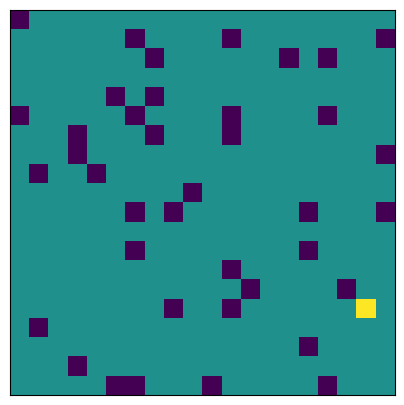

In [26]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.colormaps['viridis'])
                   
def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [27]:
anim